Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

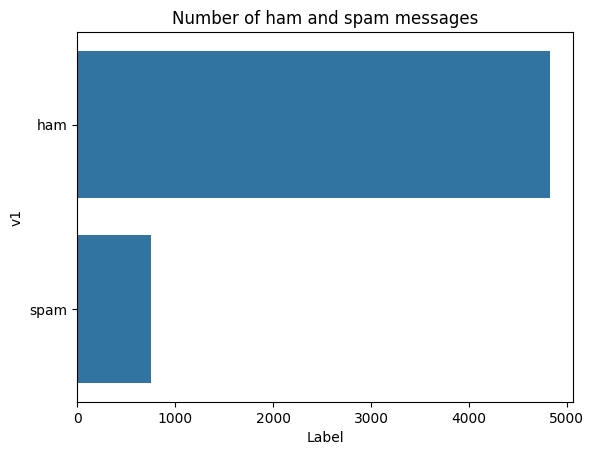

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

# Read the CSV file with proper encoding
df = pd.read_csv("spam.csv", encoding='latin-1')

sns.countplot(df.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

X = df.v2
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=5,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)
accr = model.evaluate(test_sequences_matrix,Y_test)
print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0],accr[1]))

27/27 [==============================] - 1s 6ms/step


<Figure size 800x600 with 0 Axes>

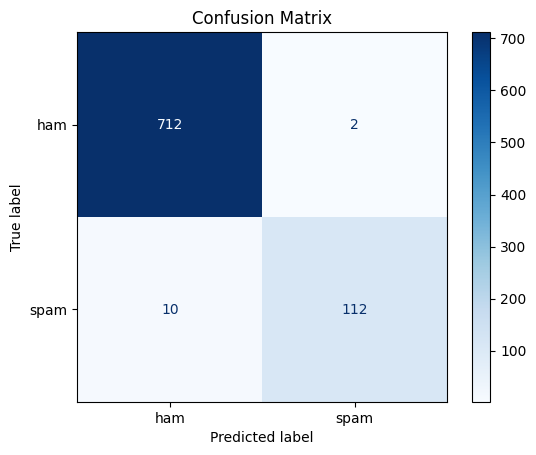

In [13]:
# Evaluate the model on the test set
y_pred = model.predict(test_sequences_matrix)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate confusion matrix
cm = confusion_matrix(Y_test, y_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ham', 'spam']).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# Choose a particular row index for testing
row_index = 0  # Change this to the desired row index

# Extract the text data from the test set for the chosen row
text_data = X_test.iloc[row_index]

# Tokenize and pad the text data
text_sequence = tok.texts_to_sequences([text_data])
text_sequence_matrix = sequence.pad_sequences(text_sequence, maxlen=max_len)

# Make predictions on the single row
prediction = model.predict(text_sequence_matrix)

# Convert prediction to binary label
binary_prediction = (prediction > 0.5).astype(int)

# Print the original text, predicted label, and probability
print("Original Text:", text_data)
print("Predicted Label (0=ham, 1=spam):", binary_prediction[0][0])
print("Probability:", prediction[0][0])


1/1 [==============================] - 0s 98ms/step
Original Text: Pls come quick cant bare this.
Predicted Label (0=ham, 1=spam): 0
Probability: 0.000768483
